## Wprowadzenie

Zadania będą polegały na implementacji różnych wariantów algorytmu Q-Learning dla dwóch środowisk z biblioteki ~~OpenAI Gym~~ Gymnasium (https://gymnasium.farama.org/): `CartPole` i `LunarLander`.

#### Uwaga: Możesz dowolnie modyfikować elementy tego notebooka (wstawiać komórki i zmieniać kod) o ile nie napisano gdzieś inaczej.

In [ ]:
# Zainstaluj bibliotekę Gymnasium i PyTorch
!pip install "gymnasium[box2d]==0.28" torch matplotlib numpy

### Środowisko `CartPole` i `LunarLander`

Poniższy kod demonstruje działanie środowiska `CartPole` (https://gymnasium.farama.org/environments/classic_control/cart_pole/) i `LunarLander` (https://gymnasium.farama.org/environments/box2d/lunar_lander/).

In [ ]:
# Zobacz jak działają środowiska na przykładzie 100 kroków
import gymnasium as gym

#env = gym.make("CartPole-v1", render_mode="human")
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()

for _ in range(100):
  # Pokaż obraz z środowiska
  env.render()

  # Wybierz losową akcję z przestrzeni akcji
  action = env.action_space.sample()

  # Wykonaj akcję i otrzymaj informację o kolejnym stanie, nagrodzie
  # i czy środowisko zostało zakończone.
  # Zobacz https://gymnasium.farama.org/api/env/#gymnasium.Env.step
  # by sprawdzić opis wszystkich zwracanych wartości.
  observation, reward, term, trunc, _ = env.step(action)
  done = term or trunc

  if done:
    observation, info = env.reset()
env.close()

In [ ]:
# Zobacz jakim typem są obserwacje (reprezentacja stanu) oraz jaka jest przestrzeń akcji:
print("Przestrzeń stanów:", env.observation_space)
print("Rozmiar wektora reprezntującego stany:", env.observation_space.shape)
print("Ostatnia obserwacja:", type(observation), observation)
print("Przestrzeń akcji:", env.action_space)
print("Ilość możliwych akcji:", env.action_space.n)

### Interface agenta

Wszystkie implementacje będą w oparciu o klasę `Agent` przedstawioną poniżej. Powinna ona implementować dwie metody:
 1. `process_transition`, która będzie wykorzystywana tylko podczas uczenia, by przekazać do agenta krotkę zawierającą obserwacje, podjętą akcję, nagrodę i następujący stan oraz informację czy jest on terminalny.
 2. `get_action` która na podstawie obserwacji zwraca akcję, dodatkowy argument informuję Agenta czy jest w aktualnie podczas uczenia czy ewaluacji.

Poniżej znajdziesz też funkcję `run_agent_in_env`, która korzysta z opisanego wyżej obiektu agenta w celu jego uczenia lub ewaluacji (podobną będziemy używać my podczas sprawdzania wszych rozwiązań). Możecie ją modyfikować jeśli widzicie taką potrzebę. Dopisaliśmy do tej funkcji rysowanie wykresu nagród z minionych epizodów, który uaktualnia się co ich zadaną liczbę.

In [ ]:
import gymnasium as gym


class Agent:
  def __init__(self, env):
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def process_transition(self, observation, action, reward, next_observation, done):
    raise NotImplementedError()

  def get_action(self, observation, learning):
    raise NotImplementedError()

In [ ]:
import pandas as pd
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline

def plot_rewards(rewards):
  plt.figure(figsize=(14, 6))
  # good amount for plotting
  plt.plot(rewards)
  plt.plot([0, len(rewards)], [0, 0], 'k--')
  # min max across all time
  plt.plot(pd.Series(rewards).expanding().min())
  plt.plot(pd.Series(rewards).expanding().max())
  # 50 % percentile
  # moving average of every 250 episodes
  plt.plot(pd.Series(rewards).rolling(250).quantile(0.5))

  display.display(plt.gcf())
  display.clear_output(wait=True)


def run_agent_in_env(env, agent, episodes, learning=False, plot=False, plot_interval=1000):
  rewards = []
  for episode in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    is_finished = False

    while not is_finished:
      action = agent.get_action(state, learning)

      next_state, reward, is_terminated, is_truncated, _ = env.step(action)
      is_finished = is_terminated or is_truncated
      total_reward += reward

      if learning: agent.process_transition(state, action, reward, next_state, is_finished)

      state = next_state
    rewards.append(total_reward)

    # Wyświetl na wykresie nagrody otrzymane po kolei w epizodach
    if plot and episode % plot_interval == 0:
      plot_rewards(rewards)
  return rewards

In [ ]:
# Demonstracja na przykładzie losowego agenta
env = gym.make("CartPole-v1")


class RandomAgent(Agent):
  def __init__(self, env):
    super().__init__(env)

  def process_transition(self, observation, action, reward, next_observation, done):
    pass

  def get_action(self, observation, learning):
    return self.action_space.sample()


random_agent = RandomAgent(env)
rewards = run_agent_in_env(env, random_agent, 10000, plot=True, plot_interval=500)

## Zad. 3.1 - Tabularyczny Q-Learning (5 pkt.)

W komórkach poniżej zaimplementuj prosty tabularyczny Q-Learning dla środowiska `CartPole`, korzystający podczas uczenia się z polityki epsilon-greedy. Ponieważ środowisko `CartPole` ma ciągłą przestrzeń stanów, musisz dokonać odpowiedniej dyskretyzacji stanów.

Odpowiedź na pytanie: dlaczego po osiągnięciu dobrych wyników obserwujemy spadek jakości? Czy możemy temu jakoś zaradzić?

Uwagi:
- Dobra polityka dająca średni wynik powyżej 200, środowisko ma limit na 500 iteracji. Polityka dająca średni wynik blisko 500 jest więc bardzo dobra.
- Uczenie nie powinno trwać więcej niż 10-15 minut na CPU.
- Postaraj się dobrać i ustawić w `__init__` takie parametry by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.


#### Uwaga: nie zmieniaj nazwy klasy `TabularQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze metody do klasy. Pomocnicze metody powinny być w tej samej komórce (sprawdzarka wyciągnie ze zgłoszonego notebooka wyłącznie komórkę z klasą `TabularQLearningAgent`, kod w innych komórkach nie będzie widziany przez sprawdzarkę!). Nie dopisuj do komórki z klasą innego kodu.

Odpowiedzi:
1. Po osiągnięciu dobrych wyników obserwujemy spadek jakości. Ponieważ agent zaczyna wybierać akcje, które nie są optymalne, ale dają mu większą szansę na eksplorację. Możemy temu zaradzić poprzez zmniejszenie wartości epsilon wraz z biegiem kolejnych epizodów, dzięki czemu agent będzie wybierał optymalne akcje.

In [8]:
import numpy as np
import random
from gymnasium import Env

class TabularQLearningAgent(Agent):
  def __init__(self, env: Env):
    super().__init__(env)
    self.gamma = 0.999
    self.epsilon = 0.5
    self.eps_decay = 0.99
    self.epsilon_min = 0.01
    self.learning_rate = 0.25
    self.bins = np.array([2, 6, 12, 6])
    # based on https://gymnasium.farama.org/environments/classic_control/cart_pole/ info
    self.bounds = np.array([4, 4, 0.4, 4])
    self.limits = np.array([2, 2, 0.2, 2])

    self.buckets = [
      np.linspace(-limit, limit, bin)
      for (limit, bin) in zip(self.limits, self.bins)
    ]

    self.quality = np.zeros((*self.bins, self.action_space.n))

  def process_transition(self, observation, action, reward, next_observation, done):
    state = self.discretize(observation)
    next_state = self.discretize(next_observation)

    prediction = self.quality[state][action]
    if done:
      target = reward
    else:
      target = reward + self.gamma * np.max(self.quality[next_state])

    self.quality[state][action] -= self.learning_rate * (prediction - target)

    if done: self.epsilon = max(self.epsilon * self.eps_decay, self.epsilon_min)

  def get_action(self, observation, learning):
    if learning and random.random() < self.epsilon: return self.action_space.sample()
    state = self.discretize(observation)
    return np.argmax(self.quality[state])

  def discretize(self, state):
    def indexer(index, value):
      (min, max) = 0, self.bins[index] - 1
      (limit, bound) = self.limits[index], self.bounds[index]
      if value <= -limit: return min
      if value >= limit: return max

      offset = max * limit / bound
      scale = max / bound
      return int(np.round(scale * value - offset))
    return tuple(map(indexer, range(len(state)), state))


Reward: 196.9707


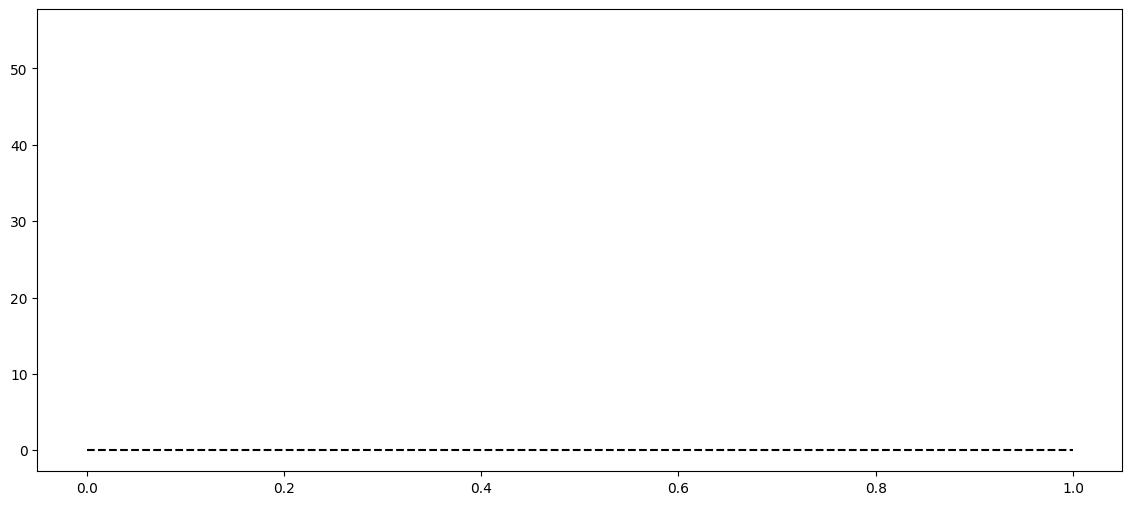

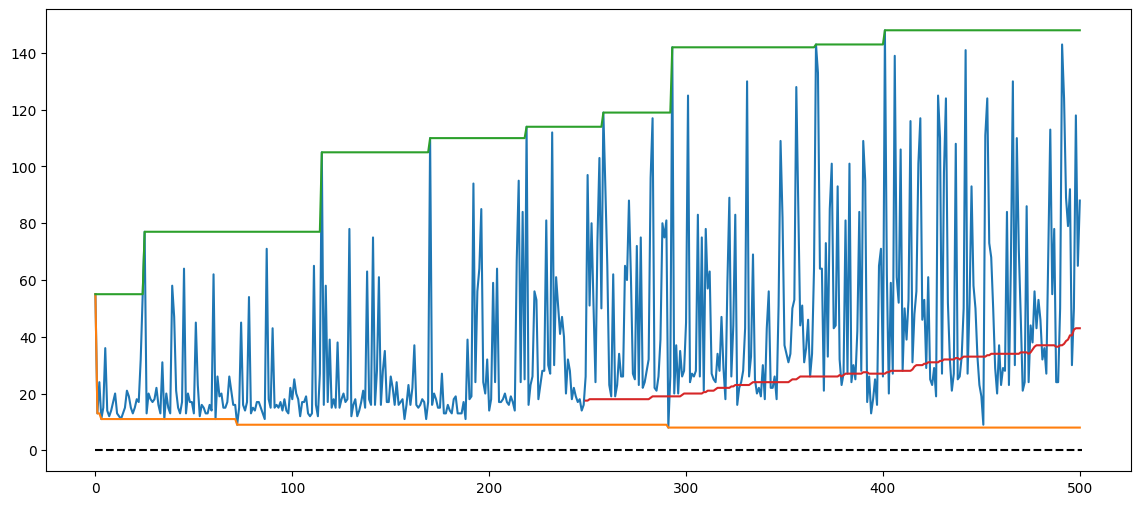

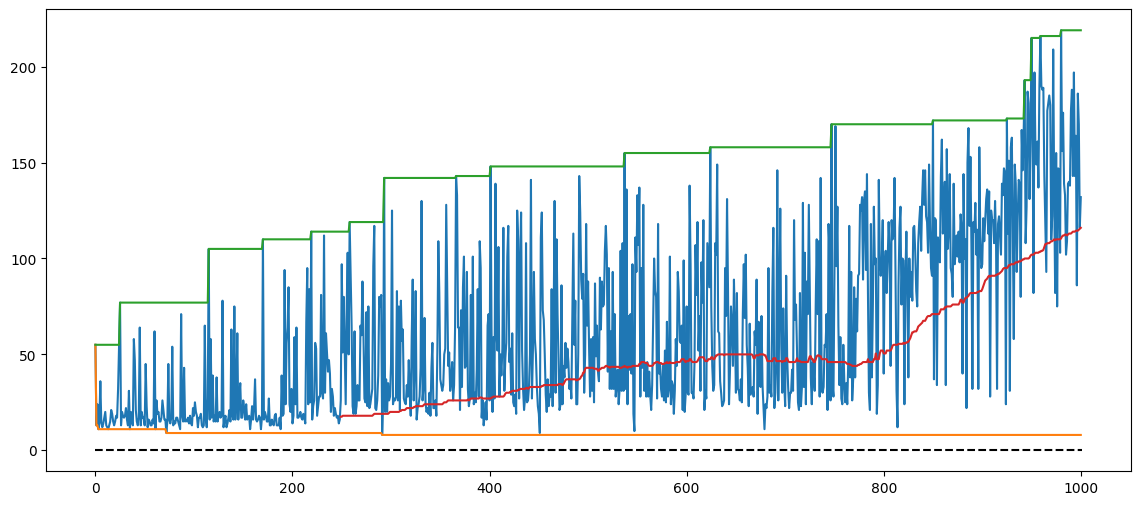

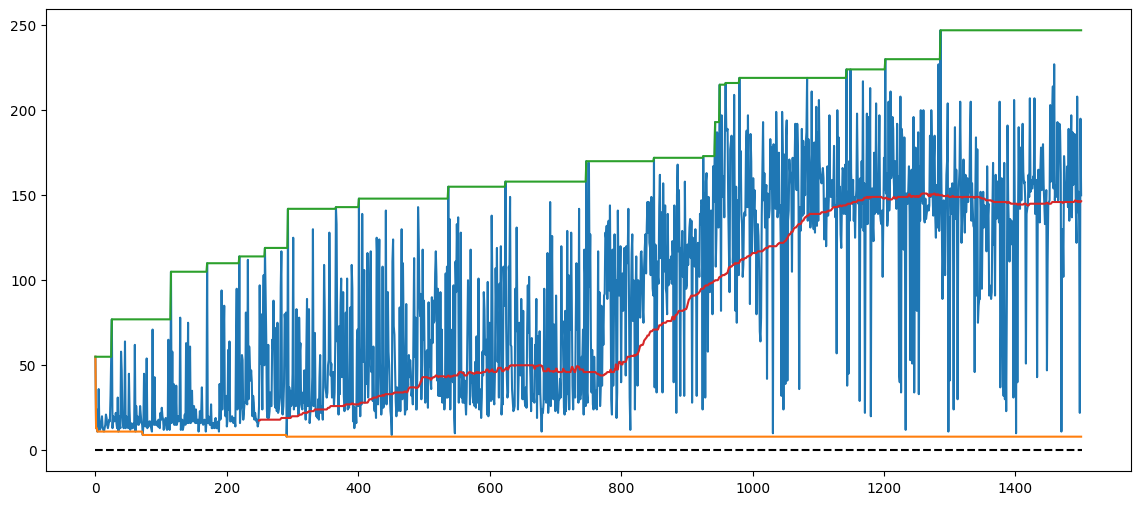

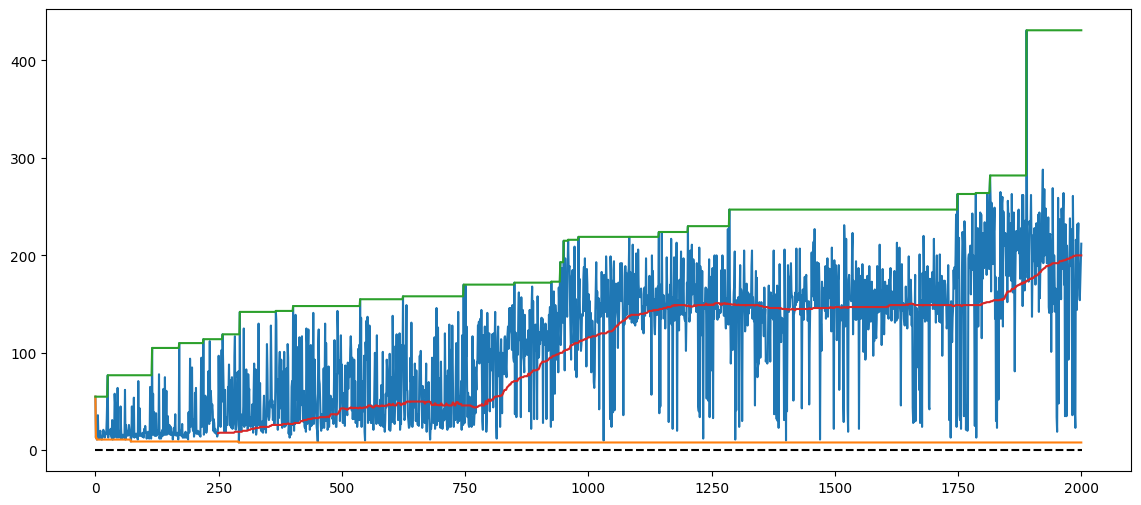

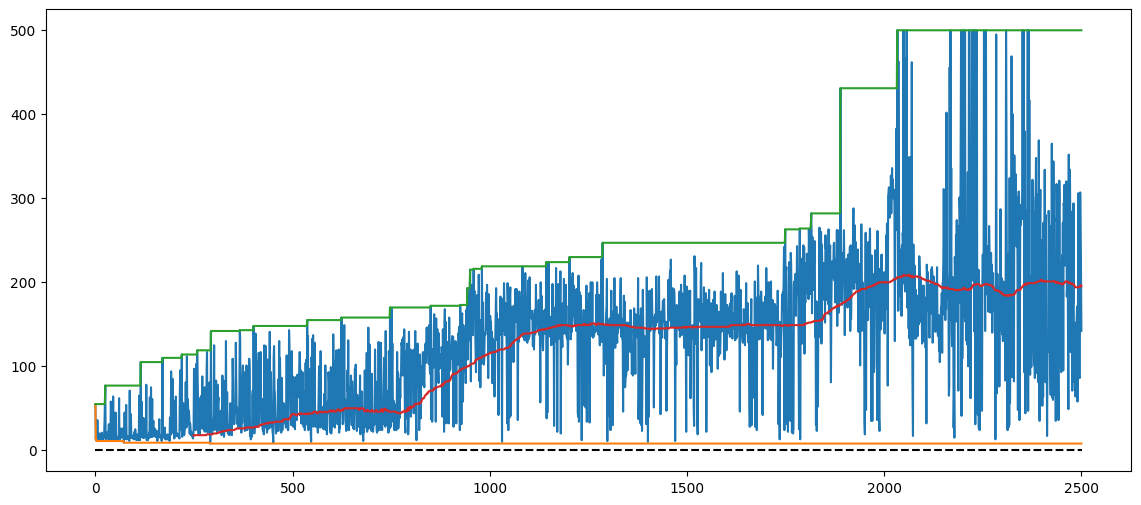

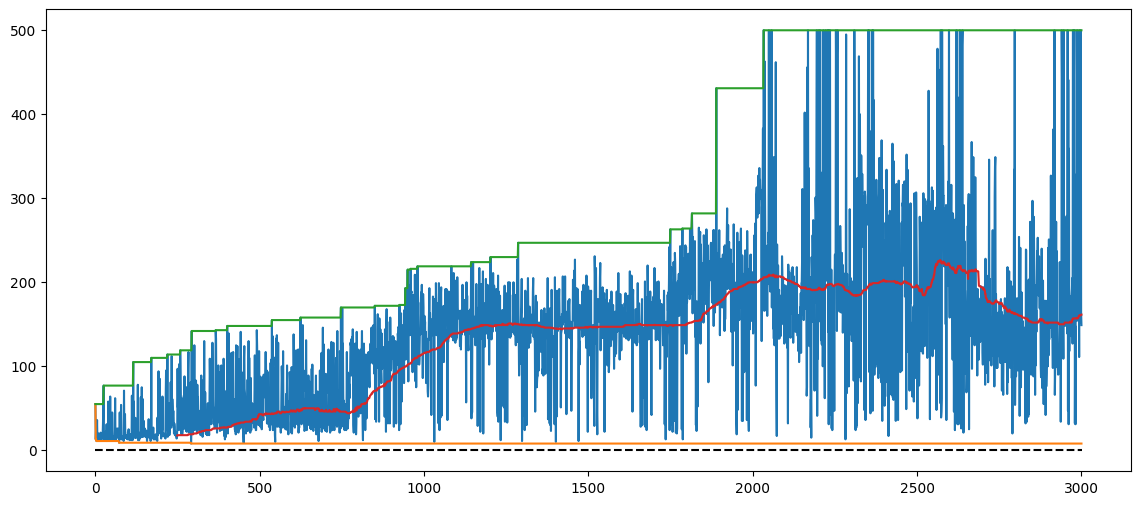

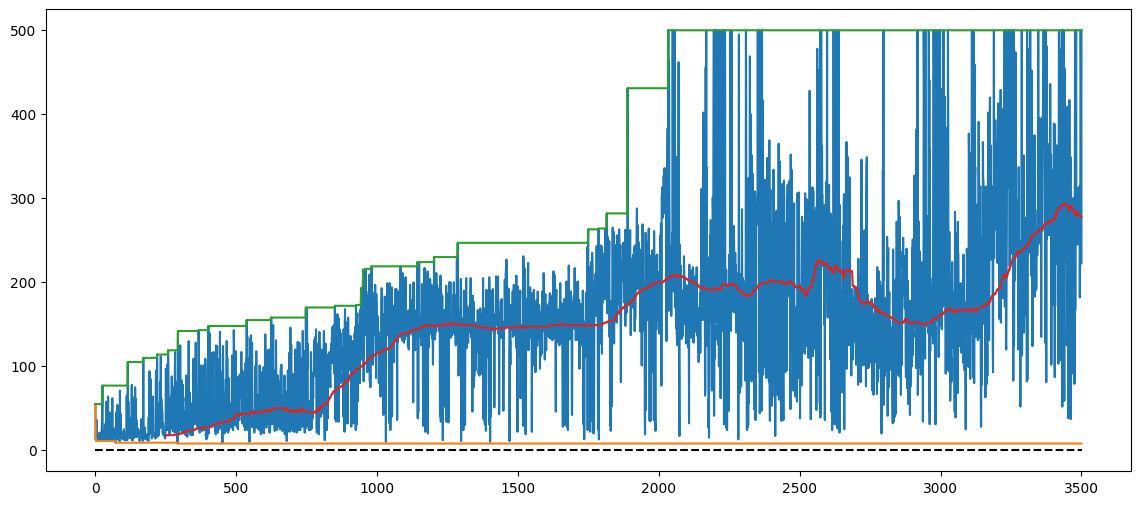

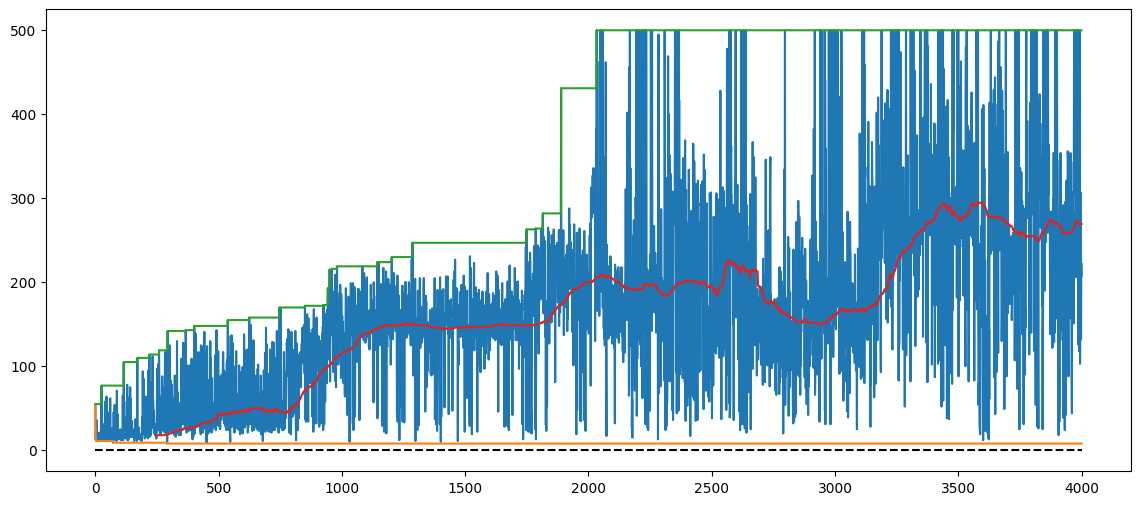

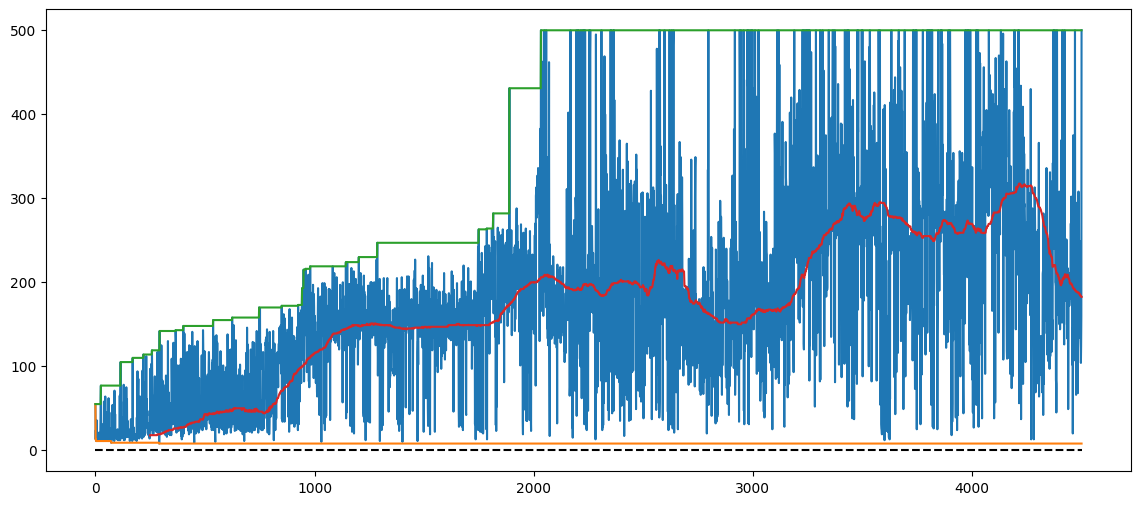

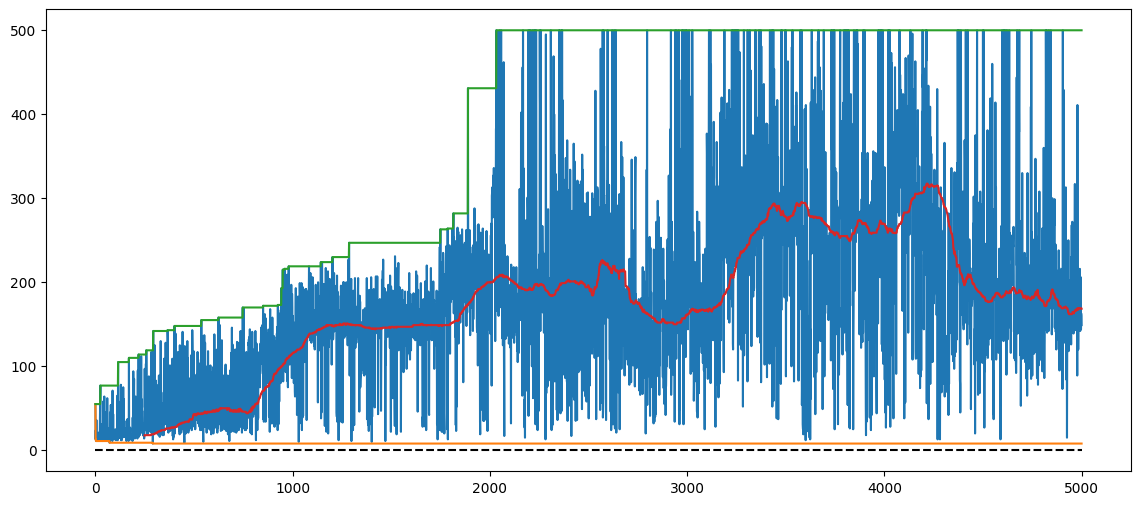

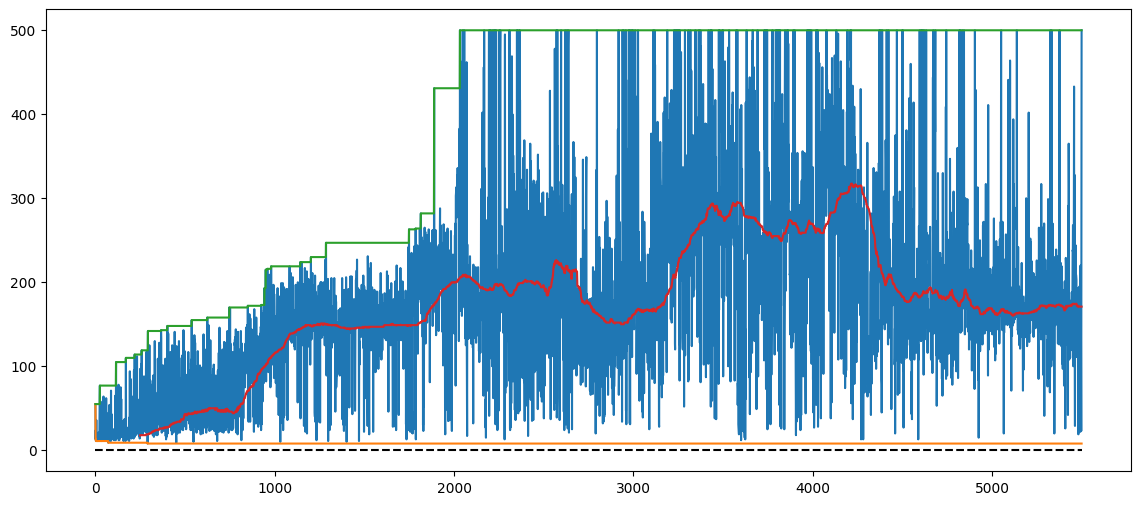

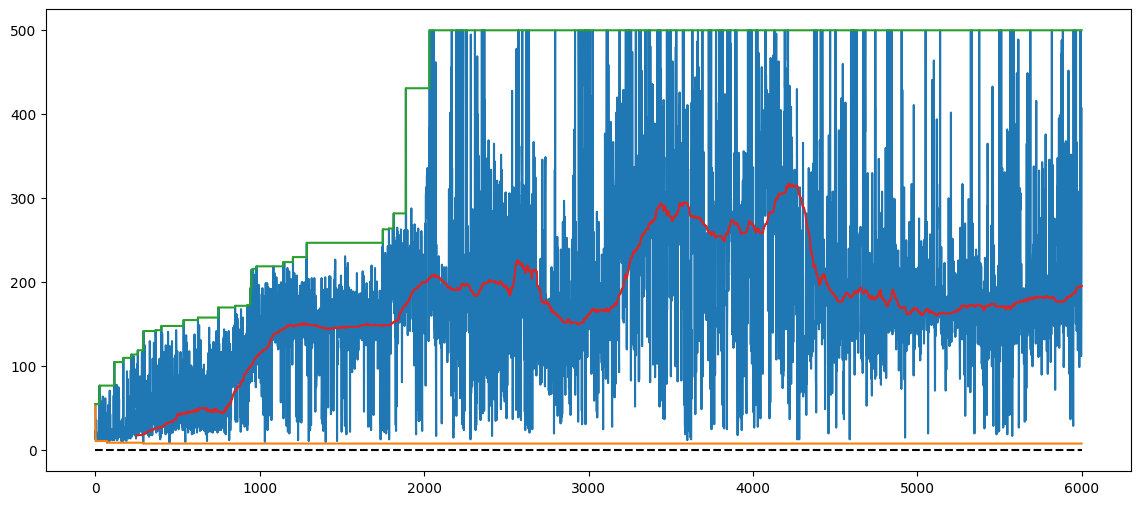

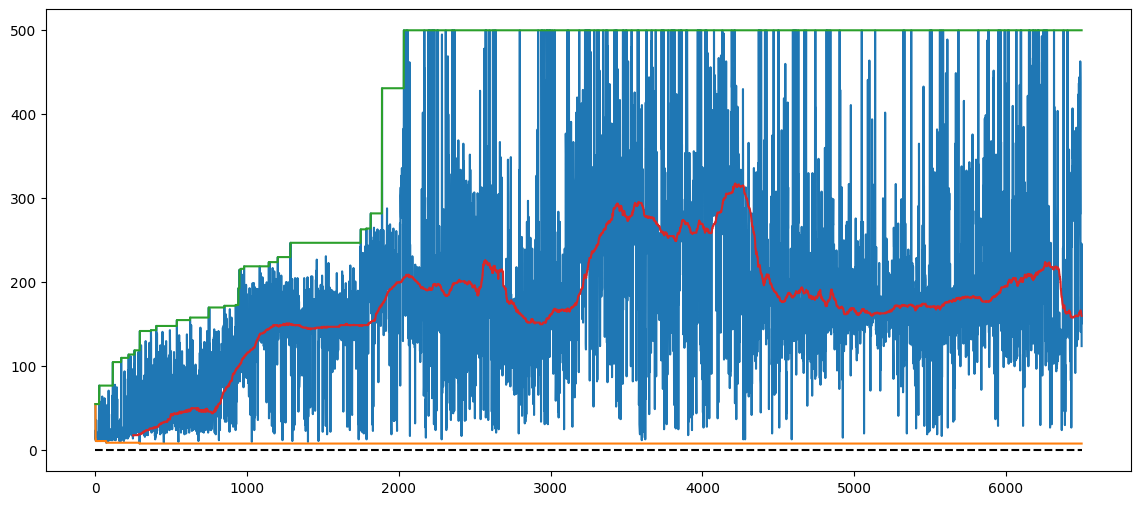

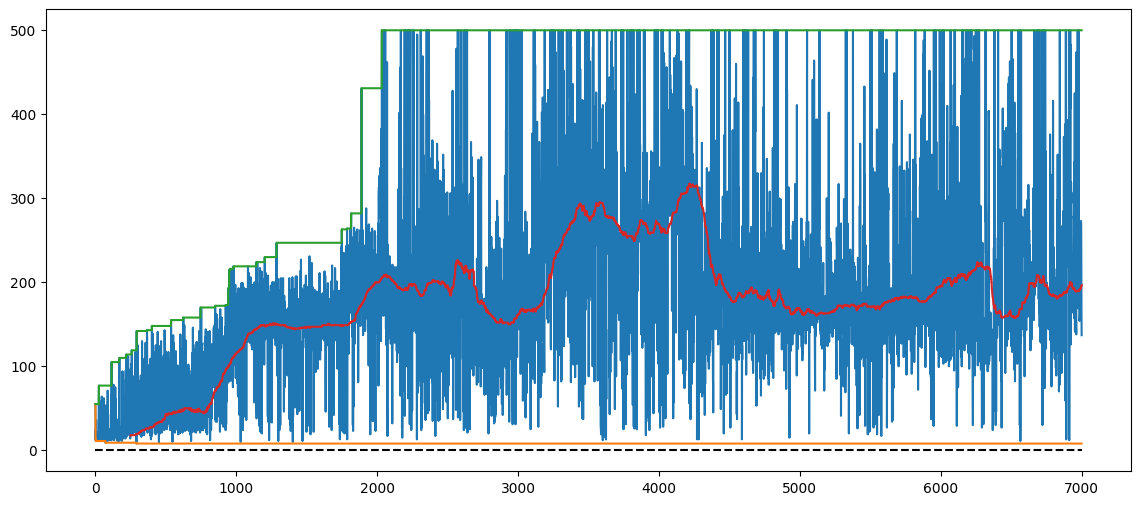

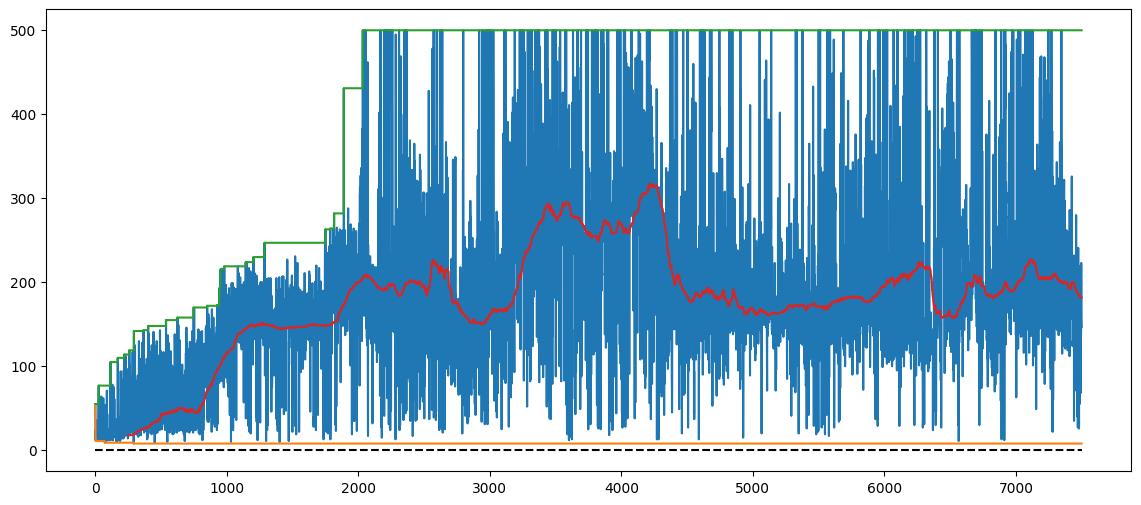

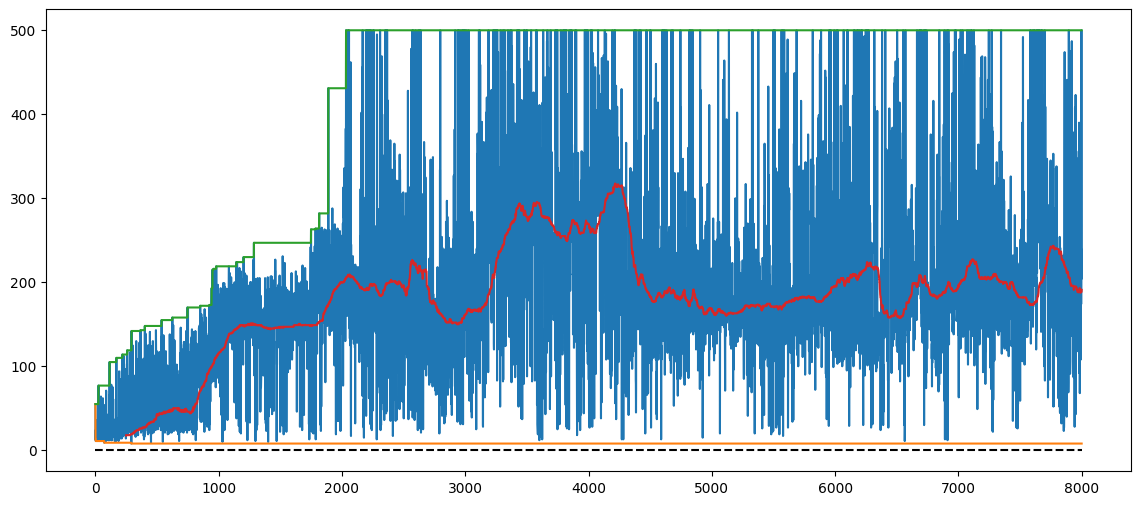

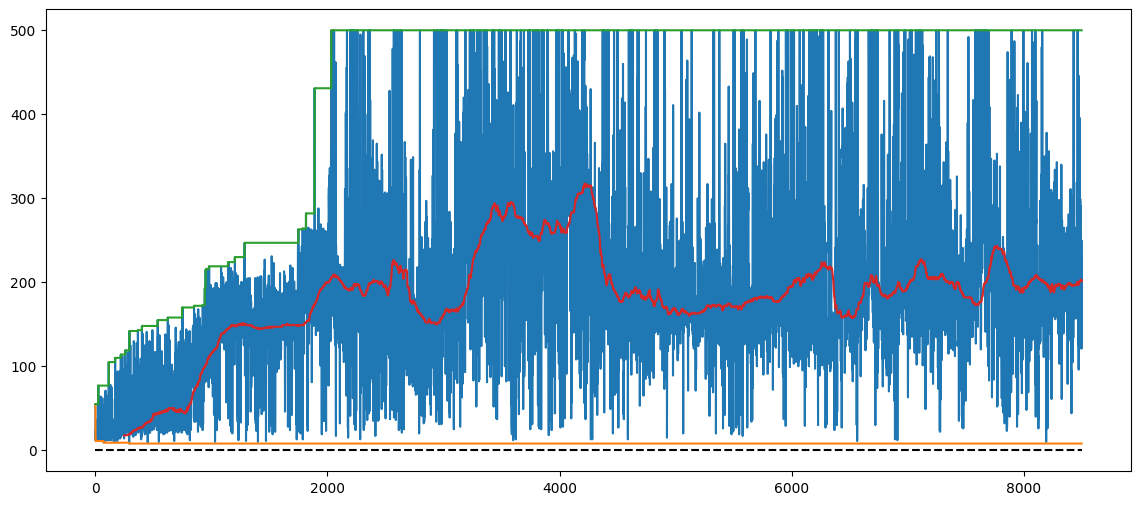

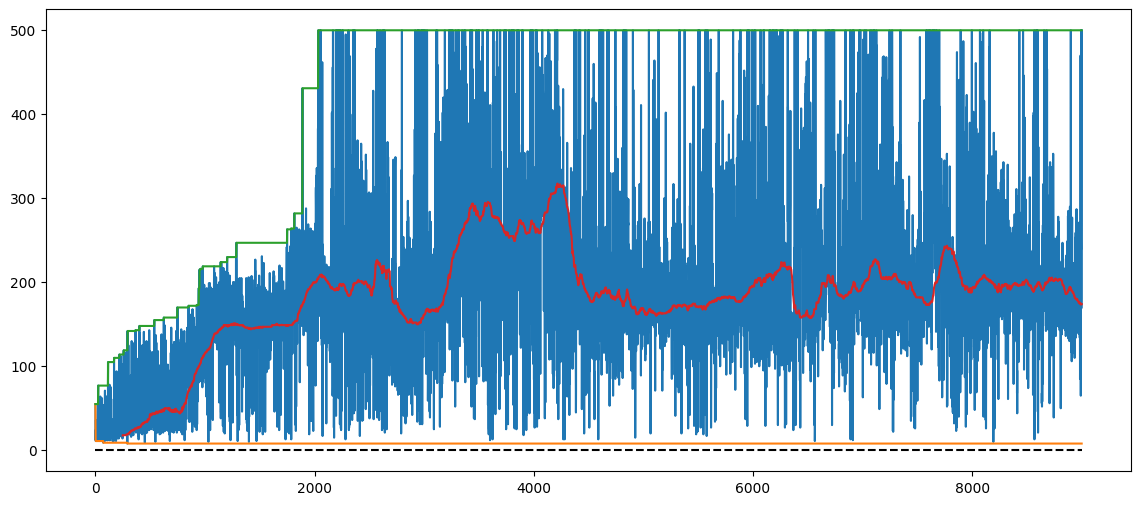

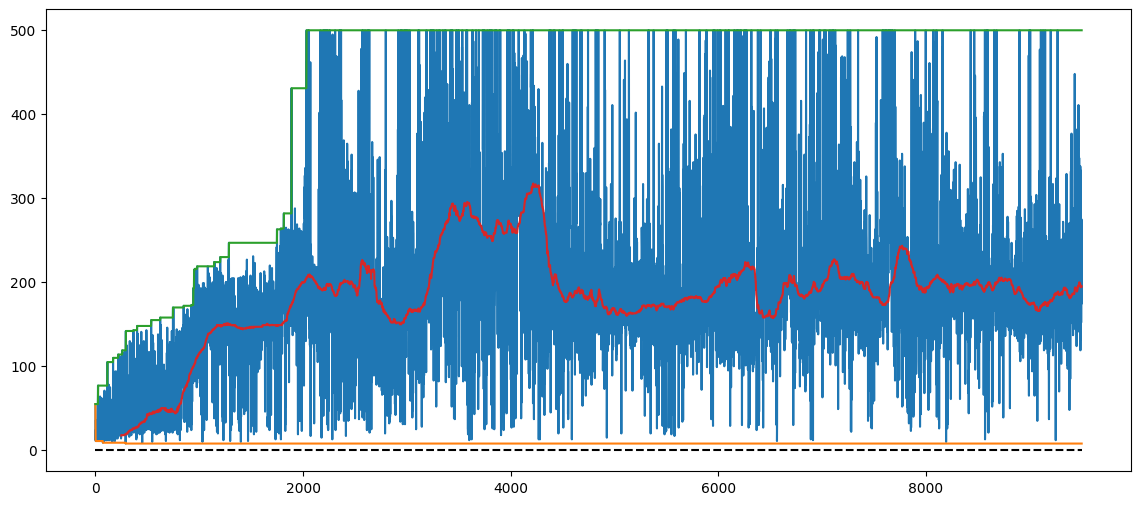

In [9]:
env = gym.make("CartPole-v1")
agent = TabularQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 10_000, learning=True, plot=True, plot_interval=500)
print(f"Reward: {np.mean(rewards)}")

## Zad. 3.2 - Q-Learning z aproksymacją (25 pkt.)

W komórkach poniżej zaimplementuj Q-Learning z aproksymacją dla środowiska `LunarLander`, korzystający podczas uczenia się z polityki epsilon-greedy, a jako aproksymatora użyj prostej sieć neuronową zaimplementowanej z wykorzystaniem biblioteki PyTroch. Zaimplementuj następujące ulepszenia algorytmu Q-Learning:
- replay memory i uczenia batchowe zamiast uczenia online jak zrobiliśmy na zajęciach
- network freezing
- double q-learning

Porównaj ze sobą różne warianty algorytmu (nie duplikuj swojej implementacji, dodaj odpowiednie argumenty w konstruktorze, które będą włączać/wyłączać odpowiednie rozszerzenie), zademonstruj oczywiście swoje wyniki pozostawiając odpowiedni output z komórek oraz je skomentuj. Opisz również, jak dokonałeś doboru parametrów Twojego modelu.

Uwagi:
- Dobra polityka powinna mieć średnią bliską 100, bardzo dobra bliską 200.
- Uczenie nie powinno trwać więcej niż 10-15 minut (przy dobrze zaimplementowanych rozszerzeniach powinno być dużo szybsze) na CPU (możesz oczywiście użyć GPU jeśli masz taką możliwość, ale zadbaj, by domyślnie Twoja implementacja działała na CPU).
- Postaraj się dobrać i ustawić w `__init__` takie parametry (w tym architekturę sieci neuronowej) by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Założona architektura nie jest potrzebna do rozwiązania tego problemu, zacznij od prostego aproksymatora (np. liniowego albo sieci z dwoma warstwami) i stopniowo zwiększaj jego złożoność.
- Możesz najpierw testować swoją implementację na środowisku `CartPole`, jest to prostszy problem i z dobrymi parametrami nawet prosta wersja Q-Learningu z aproksymacją powinna się go uczyć w nie więcej niż 2-3 minuty na CPU.

#### Uwaga: nie zmieniaj nazwy klasy `NeuralQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze metody do klasy. Pomocnicze metody powinny być w tej samej komórce (sprawdzarka wyciągnie ze zgłoszonego notebooka wyłącznie komórkę z klasą `NeuralQLearningAgent`, kod w innych komórkach nie będzie widziany przez sprawdzarkę!). Nie dopisuj do komórki z klasą innego kodu.

Odpowiedzi: Miejsce na Twoje odpowiedzi

In [ ]:
from random import sample
import torch


class QModel(torch.nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.model = torch.nn.Sequential(
      torch.nn.Linear(input_size, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, output_size)
    )

  def forward(self, x):
    return self.model(x)

  def predict(self, x):
    with torch.no_grad():
      return self.forward(torch.Tensor(x))


class NeuralQLearningAgent(Agent):
  def get_action(self, observation, learning):
    if learning and np.random.random() < self.epsilon:  return self.action_space.sample()
    return torch.argmax(self.model.predict(observation)).item()

  def __init__(self, env, use_replay=False, use_batch=False, use_network_freeze=False, use_double_q_learning=False):
    super().__init__(env)
    self.model = QModel(env.observation_space.shape[0], env.action_space.n)
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001)
    self.loss_fn = torch.nn.MSELoss()

    self.gamma = 0.99
    self.epsilon = 0.2
    self.epsilon_decay = 0.999
    self.epsilon_min = 0.01

  def process_transition(self, observation, action, reward, next_observation, done):
    state = torch.Tensor(observation)
    next_state = torch.Tensor(next_observation)
    action = torch.LongTensor([action])
    reward = torch.Tensor([reward])

    self.optimizer.zero_grad()
    predicted = self.model(state)[action]
    if done:
      target = reward
    else:
      target = reward + self.gamma * torch.max(self.model(next_state))

    loss = self.loss_fn(predicted, target)
    loss.backward()
    self.optimizer.step()
    if done: self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [ ]:
# check gpu
import torch
print(torch.cuda.is_available())

# check if used
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))


In [ ]:
# Uczenie/testowania agenta
env = gym.make("CartPole-v1")
agent = NeuralQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 10000, learning=True, plot=True, plot_interval=100)